#P0: Intro
In this notebook, we fine-tune a pre-trained transformer model for image classification on the cifar10 dataset. Utilizing the Vision Transformer (ViT) model, we adapt it for computer vision tasks by tokenizing images similarly to text, enabling the model to process images as sequences of embedded patches. This approach allows us to leverage the power of transformers, originally designed for natural language processing, in classifying images of cifar10 dataset.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall accelerate transformers -y
!pip install accelerate transformers

Found existing installation: transformers 4.41.0
Uninstalling transformers-4.41.0:
  Successfully uninstalled transformers-4.41.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 40.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached 

In [ ]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# P1: Load the dataset (10 points)

Load the dataset and show some images with the labels.

In [ ]:
# load cifar10 (only small portion for demonstration purposes)
train_ds, test_ds = load_dataset('cifar10', split=['train[:]', 'test[:]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.2)
train_ds = splits['train']
val_ds = splits['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import torch
from sklearn.metrics import accuracy_score
from transformers import ViTImageProcessor
from transformers import TrainingArguments, Trainer
from transformers import ViTForImageClassification
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

In [ ]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 40000
})

In [ ]:
val_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [ ]:
test_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [ ]:
train_ds.features

{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

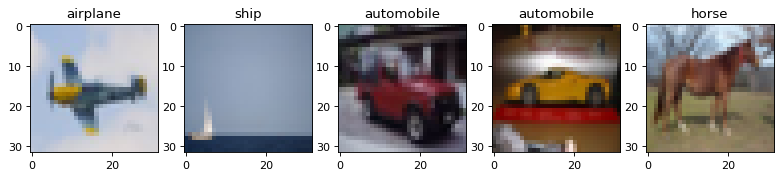

In [ ]:
plt.figure(figsize=(12, 10), dpi=80)
# Print some sample images with labels
num_images = 5
for i in range(num_images):
  # Rescale image pixels to be between 0 and 1
  image = train_ds[i]['img']
  # Get the label index
  label_index = train_ds[i]['label']
  # Get the class name based on the label index
  class_name = id2label[label_index]
  plt.subplot(1, 5, i+1)
  plt.imshow(image)
  plt.title(class_name)

# P2: Data Preprocessing (40 points)

# pytorch

In [ ]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [ ]:
print(size)

224


In [ ]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

# P3: Training and Evaluation (150 points)



In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/HW3_Q2/models",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    num_train_epochs=1,
    metric_for_best_model=metric_name,
        load_best_model_at_end=True,
    logging_dir='/content/drive/MyDrive/HW3_Q2/log',
    remove_unused_columns=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Accuracy
1,0.082400,0.060934,0.984800


TrainOutput(global_step=5000, training_loss=0.1783914939880371, metrics={'train_runtime': 1630.0167, 'train_samples_per_second': 24.54, 'train_steps_per_second': 3.067, 'total_flos': 3.09990183616512e+18, 'train_loss': 0.1783914939880371, 'epoch': 1.0})

**Evaluation**

In [ ]:
outputs = trainer.predict(test_ds)

In [ ]:
print(outputs.metrics)

{'test_loss': 0.0779571458697319, 'test_accuracy': 0.9804, 'test_runtime': 120.558, 'test_samples_per_second': 82.948, 'test_steps_per_second': 10.368}


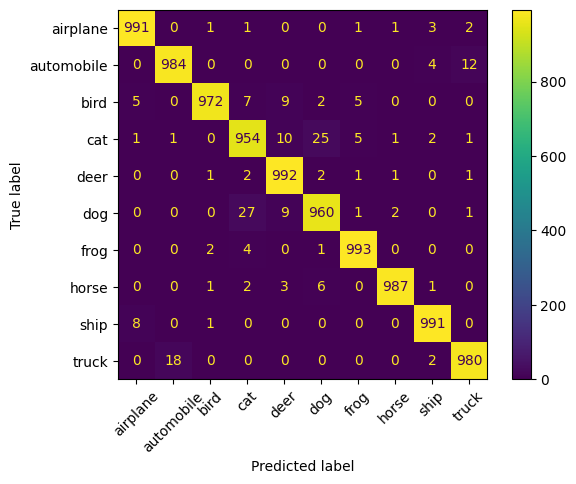

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

## model link:

https://drive.google.com/drive/folders/1CXS38BDCCU0rgSSFiPM89VjydC70Qob4?usp=sharing



## results:

train accuracy = 0.9848

test accuracy = 0.9804

# sites:

https://ai-brewery.medium.com/vision-transformers-on-cifar-10-dataset-part-1-16db89706077

https://keras.io/examples/vision/image_classification_with_vision_transformer/

https://github.com/cloudstrife1117/VisionTransformer

https://huggingface.co/docs/transformers/en/main_classes/trainer

https://huggingface.co/docs/transformers/en/main_classes/image_processor

https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb

